# **Task 1: LLM Fundamentals & Generation Analysis**

## **Overview**
This task provides a **hands-on introduction** to the fundamentals of large language models (LLMs) using the **Llama 3-8B Instruct** model.  
It walks through model loading, text generation experiments, and key performance analyses, focusing on **latency**, **diversity**, and **memory usage**.

---

## **Step 1: Environment Setup (Cell 2)**

- **Objective:**  
  Create a clean and reproducible environment for running all experiments.

- **Actions:**
  - **Import Libraries:**  
    Load all required libraries for model handling, generation, and visualization.  
  - **Configure Environment:**  
    Define a `set_seed` function to ensure reproducibility by fixing random seeds.  
    Verify that a **GPU** is available for efficient computation.

---

## **Step 2: Model Loading (Cell 4)**

- **Objective:**  
  Load the target **Llama 3-8B Instruct** model and prepare it for inference.

- **Actions:**
  - **Select Model:**  
    Set `MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"`.  
  - **Load with Fallback:**  
    Use a `try...except` block to attempt loading the main model.  
    If it fails (e.g., due to limited memory), load a smaller fallback model (`FALLBACK_MODEL_ID`) to ensure the notebook remains executable.  
  - **Model Summary:**  
    Print key information about the loaded model, including size and configuration.

---

## **Step 3: Experiment 1 — Effect of Temperature on Diversity (Cell 5)**

- **Objective:**  
  Understand how the **temperature** hyperparameter influences the **randomness and diversity** of generated text.

- **Actions:**
  - **Set Parameters:**  
    Define a fixed input `PROMPT` and a list of `TEMPERATURES` to test.  
  - **Generate Samples:**  
    Loop through each temperature value and generate multiple text samples using  
    `model.generate(..., do_sample=True)` so that temperature actually affects randomness.  
  - **Record Results:**  
    Save all generated outputs for side-by-side comparison and qualitative analysis.

---

## **Step 4: Experiment 2 — Input Length vs. Prefill Latency (Cell 6)**

- **Objective:**  
  Demonstrate that **longer input sequences** lead to **higher prefill latency** before generation begins.

- **Actions:**
  - **Define Input Sizes:**  
    Create a list of token lengths (`INPUT_LENGTHS`) to test various input sizes.  
  - **Precise Timing:**  
    Use `torch.cuda.Event` for high-precision GPU time measurement.  
  - **Measure Prefill Stage:**  
    For each input length, perform warm-up runs, then measure time for generating one token (`max_new_tokens=1`) to isolate prefill cost.  
  - **Visualize:**  
    Plot a line graph showing **input length (x-axis)** vs. **average latency (y-axis)**.

---

## **Step 5: Experiment 3 — Real-Time Memory Tracking During Generation (Cell 8)**

- **Objective:**  
  Track and visualize **GPU memory usage** step-by-step as tokens are generated, illustrating the growth of the **KV Cache**.

- **Actions:**
  - **Design a “Memory Hook”:**  
    Implement a custom class `MemoryUsageCallback` inheriting from `transformers.StoppingCriteria`.  
    Its `__call__` method records current GPU memory after each token generation, returning `False` to continue.  
  - **Run Monitored Generation:**  
    After GPU warm-up, create an instance of the callback and pass it to `model.generate()` via `stopping_criteria`.  
  - **Analyze and Plot:**  
    Convert recorded memory data into a DataFrame and plot the **memory usage curve** over generation steps.

---

## **Step 6: Verifying the Space Complexity of KV Cache (Cell 9)**

- **Objective:**  
  Quantitatively confirm that memory usage grows **linearly** with sequence length — proving **O(L)** space complexity for the KV Cache.

- **Actions:**
  - **Linear Regression:**  
    Apply `scipy.stats.linregress` to fit a linear model between the number of generated tokens and memory increase.  
  - **Interpret Results:**  
    - The **slope** indicates average memory growth (in MB) per generated token.  
    - The **R² value** close to 1 (e.g., > 0.99) validates a strong linear correlation, confirming the **O(L)** relationship.

---

## **Step 7: Summary and Analysis (Cell 10)**

- **Objective:**  
  Summarize all experimental findings and explain the underlying principles observed.

- **Actions:**
  - **Write Analysis:**  
    Discuss results and plots from all experiments, highlighting:  
    - The trade-off between temperature and diversity.  
    - The linear scaling of prefill latency with input length.  
    - The direct, linear memory growth due to KV caching.  
  - Synthesize these insights into a clear, data-driven conclusion about **LLM generation efficiency** and **scalability**.


In [1]:
### Cell 2: Environment Setup and Dependency Installation
# TODO: import all required libraries for the lab (os, random, time, numpy, pandas, torch, transformers, etc.)

import os
import random
import time
import numpy as np
import pandas as pd
import torch
import transformers

RESULTS_DIR = "./results"
FIGURES_DIR = "./figures"

# TODO: create the results/figures directories if they do not exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# TODO: configure logging verbosity and select DEVICE (cuda vs. cpu)
device = "cuda"
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available!")
else:
    # Check for some stupid error on PACE where CUDA actually is not supported
    a = torch.randn(1024, 1024, device=device)
    b = torch.randn(1024, 1024, device=device)
    c = torch.matmul(a, b)
    print(f"Did CUDA work? {c.sum()}")

# TODO: print environment diagnostics (CUDA version, PyTorch version, etc.)

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch RNGs for reproducible lab runs."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
print("Environment initialised.")


/home/hice1/samin68/scratch/miniconda3/envs/cs4650/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Did CUDA work? 8251.701171875
Environment initialised.


In [ ]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# # Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        # custom token made for this project, no security risk here
        hf_token = "removed"
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
   Hugging Face login successful!


In [3]:
### Cell 4: Load Model and Tokenizer
MODEL_ID = "meta-llama/Llama-3-8B-Instruct"
FALLBACK_MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"

from transformers import AutoModelForCausalLM, AutoTokenizer

model = None
tokenizer = None

candidates = [MODEL_ID, FALLBACK_MODEL_ID]

for candidate in candidates:
    # TODO: attempt to load tokenizer/model and break once successful
    try:
        model = AutoModelForCausalLM.from_pretrained(
            candidate,
            device_map=device, 
            dtype="auto"        
        )
        tokenizer = AutoTokenizer.from_pretrained(candidate)


        print(f"Successfully loaded model: {candidate}")
    except Exception as e:
        print(f"Failed to load {candidate}, trying next model...")
        print(f"{e}")

# TODO: raise an error if both candidates fail to load
if model is None or tokenizer is None:
    raise RuntimeError("Failed to load any candidate model!")

# TODO: ensure tokenizer/model pad tokens are configured
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# TODO: move model to eval mode/device and print summary stats
model.eval()
print(model)


Failed to load meta-llama/Llama-3-8B-Instruct, trying next model...
meta-llama/Llama-3-8B-Instruct is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`


Loading checkpoint shards: 100%|██████████| 4/4 [01:28<00:00, 22.03s/it]


Successfully loaded model: meta-llama/Llama-3.1-8B-Instruct
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
   

In [4]:
### Cell 5: Experiment 1 - Effect of Temperature on Generation Diversity
print("--- Experiment 1: Temperature sweep ---")

PROMPT = "Prove the power rule used in differential calculus."  # TODO: provide the experiment prompt
TEMPERATURES = [0.3, 0.5, 0.7, 1.0]  # TODO: define the temperatures to test
NUM_SAMPLES_PER_TEMP = 5  # TODO: samples per temperature
MAX_NEW_TOKENS = 2048  # TODO: maximum generation length

# TODO: ensure model and tokenizer are loaded before running

records = []

import tqdm


inputs = tokenizer(PROMPT, return_tensors="pt").to(model.device)
prompt_length = inputs.input_ids.shape[-1]

print(f"Prompt length: {prompt_length}")

for temp in TEMPERATURES:
    for sample_id in range(1, NUM_SAMPLES_PER_TEMP + 1):
        print(f"Processing temp {temp} sample {sample_id}/{NUM_SAMPLES_PER_TEMP}")
        # Tokenize prompt
        
        # Generate completion
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=temp,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
        
        # Decode output
        response_tokens = outputs[0][prompt_length:]

        completion = tokenizer.decode(response_tokens, skip_special_tokens=True).strip()
        completion_length = response_tokens.shape[0]
        
        # Store record
        records.append({
            'temperature': temp,
            'completion': completion,
            'completion_length': completion_length
        })

# TODO: build df_temperature and summary_temperature from records
df_temperature = pd.DataFrame(records)

summary_temperature = df_temperature.groupby('temperature').agg({
    'completion_length': ['mean', 'std', 'min', 'max'],
    'completion': lambda x: len(set(x))  # unique completions
}).round(2)

# TODO: persist CSV artifacts and display summary statistics
df_temperature.to_csv("results/task_1_df_temprature.csv")
summary_temperature.to_csv("results/task_1_summary_temperature.csv")

print("Temperature sweep complete. Summary statistics:")
print(summary_temperature)

print("Text generations:")
print(df_temperature)


--- Experiment 1: Temperature sweep ---
Prompt length: 11
Processing temp 0.3 sample 1/5
Processing temp 0.3 sample 2/5
Processing temp 0.3 sample 3/5
Processing temp 0.3 sample 4/5
Processing temp 0.3 sample 5/5
Processing temp 0.5 sample 1/5
Processing temp 0.5 sample 2/5
Processing temp 0.5 sample 3/5
Processing temp 0.5 sample 4/5
Processing temp 0.5 sample 5/5
Processing temp 0.7 sample 1/5
Processing temp 0.7 sample 2/5
Processing temp 0.7 sample 3/5
Processing temp 0.7 sample 4/5
Processing temp 0.7 sample 5/5
Processing temp 1.0 sample 1/5
Processing temp 1.0 sample 2/5
Processing temp 1.0 sample 3/5
Processing temp 1.0 sample 4/5
Processing temp 1.0 sample 5/5
Temperature sweep complete. Summary statistics:
            completion_length                    completion
                         mean     std  min   max   <lambda>
temperature                                                
0.3                    1213.2  763.30  586  2048          5
0.5                    1466.8  650

In [5]:
inputs = tokenizer(PROMPT, return_tensors="pt").to(model.device)
print(inputs)

{'input_ids': tensor([[128000,   1360,    588,    279,   2410,   6037,   1511,    304,  41264,
          83768,     13]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


--- Experiment 2: Input length vs. prefill latency ---
Running warmup for 16


100%|██████████| 16/16 [00:00<00:00, 54.10it/s]


Running trials for 16


100%|██████████| 32/32 [00:00<00:00, 59.23it/s]


Running warmup for 32


100%|██████████| 16/16 [00:00<00:00, 54.71it/s]


Running trials for 32


100%|██████████| 32/32 [00:00<00:00, 59.84it/s]


Running warmup for 64


100%|██████████| 16/16 [00:00<00:00, 57.82it/s]


Running trials for 64


100%|██████████| 32/32 [00:00<00:00, 60.01it/s]


Running warmup for 128


100%|██████████| 16/16 [00:00<00:00, 57.26it/s]


Running trials for 128


100%|██████████| 32/32 [00:00<00:00, 60.08it/s]


Running warmup for 192


100%|██████████| 16/16 [00:00<00:00, 57.41it/s]


Running trials for 192


100%|██████████| 32/32 [00:00<00:00, 60.47it/s]


Running warmup for 256


100%|██████████| 16/16 [00:00<00:00, 58.39it/s]


Running trials for 256


100%|██████████| 32/32 [00:00<00:00, 60.69it/s]


Running warmup for 384


100%|██████████| 16/16 [00:00<00:00, 50.73it/s]


Running trials for 384


100%|██████████| 32/32 [00:00<00:00, 52.58it/s]


Running warmup for 512


100%|██████████| 16/16 [00:00<00:00, 45.00it/s]


Running trials for 512


100%|██████████| 32/32 [00:00<00:00, 46.23it/s]


Running warmup for 768


100%|██████████| 16/16 [00:00<00:00, 34.38it/s]


Running trials for 768


100%|██████████| 32/32 [00:00<00:00, 34.51it/s]


Running warmup for 1024


100%|██████████| 16/16 [00:00<00:00, 28.28it/s]


Running trials for 1024


100%|██████████| 32/32 [00:01<00:00, 28.44it/s]


Running warmup for 1536


100%|██████████| 16/16 [00:00<00:00, 18.98it/s]


Running trials for 1536


100%|██████████| 32/32 [00:01<00:00, 18.93it/s]


Running warmup for 2048


100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


Running trials for 2048


100%|██████████| 32/32 [00:02<00:00, 14.61it/s]


Summary stats:
              prefill_time                              
                      mean       std       min       max
prompt_length                                           
16                0.016826  0.000082  0.016689  0.017112
32                0.016659  0.000072  0.016556  0.016832
64                0.016620  0.000105  0.016475  0.017001
128               0.016603  0.000133  0.016444  0.017054
192               0.016497  0.000111  0.016338  0.016847
256               0.016433  0.000112  0.016309  0.016879
384               0.018969  0.000060  0.018883  0.019160
512               0.021571  0.000075  0.021495  0.021797
768               0.028898  0.000695  0.027955  0.031223
1024              0.035061  0.000328  0.034518  0.036076
1536              0.052665  0.000726  0.051790  0.055275
2048              0.068281  0.000994  0.066503  0.069849


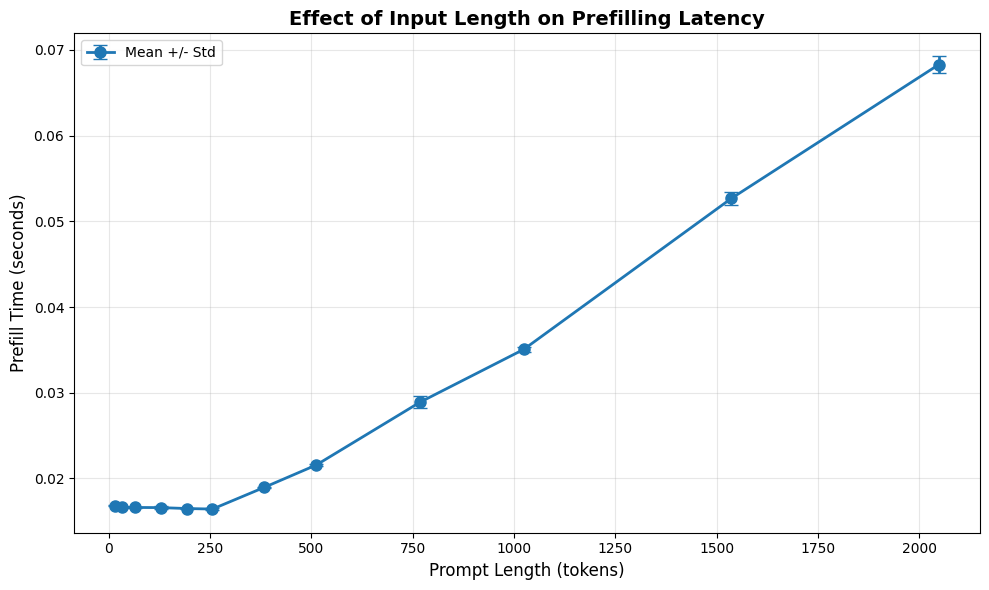

<Figure size 640x480 with 0 Axes>

In [6]:
### Cell 6: Experiment 2 - Effect of Input Length on Prefilling Latency
print("--- Experiment 2: Input length vs. prefill latency ---")

LATENCY_INPUT_LENGTHS = [16, 32, 64, 128, 192, 256, 384, 512, 768, 1024, 1536, 2048]  # TODO: sorted list of token lengths
NUM_WARMUP = 16  # TODO: number of warmup passes
NUM_TRIALS = 32  # TODO: number of timed trials
MAX_NEW_TOKENS = 1  # TODO: max generation length per latency run

latency_records = []

for input_length in LATENCY_INPUT_LENGTHS:
    # TODO: build a dummy prompt of the desired token length
    inputs = {
        "input_ids": torch.randint(low=0, high=len(tokenizer), size=(1, input_length), device=device),
        "attention_mask": torch.ones(1, input_length, device=device)
    }

    # warmup generations
    print(f"Running warmup for {input_length}")
    for _ in tqdm.tqdm(range(NUM_WARMUP)):
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    torch.cuda.synchronize()

    # time trial generations and record latency/throughput
    print(f"Running trials for {input_length}")
    for _ in tqdm.tqdm(range(NUM_TRIALS)):
        start = time.time()

        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

        torch.cuda.synchronize()

        elapsed = time.time() - start

        latency_records.append({
            "prompt_length": input_length,
            "prefill_time": elapsed
        })


# TODO: assemble df_latency from latency_records
df_latency = pd.DataFrame(latency_records)

# TODO: compute summary statistics and optionally plot latency curves
summary_latency = df_latency.groupby("prompt_length").agg({
    "prefill_time": ["mean", "std", "min", "max"],
})

print("Summary stats:")
print(summary_latency)

import matplotlib.pyplot as plt
# plt.figure(...)
# plt.savefig(...)
# Plot latency curves
plt.figure(figsize=(10, 6))
plt.errorbar(summary_latency.index, 
             summary_latency[("prefill_time", "mean")],
             yerr=summary_latency[("prefill_time", "std")],
             marker='o', 
             capsize=5,
             linewidth=2,
             markersize=8,
             label='Mean +/- Std')
plt.xlabel('Prompt Length (tokens)', fontsize=12)
plt.ylabel('Prefill Time (seconds)', fontsize=12)
plt.title('Effect of Input Length on Prefilling Latency', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

df_latency.to_csv('results/task_1_df_latency.csv', index=False)
summary_latency.to_csv('results/task_1_summary_latency.csv', index=False)
plt.savefig('figures/task_1_latency.png', dpi=300, bbox_inches='tight')


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


--- Experiment 3: Real-time memory trace ---
     step     memory_mb  memory_increase_mb
123   123  15385.662109               0.125
124   124  15385.787109               0.125
125   125  15385.912109               0.125
126   126  15386.037109               0.125
127   127  15386.162109               0.125


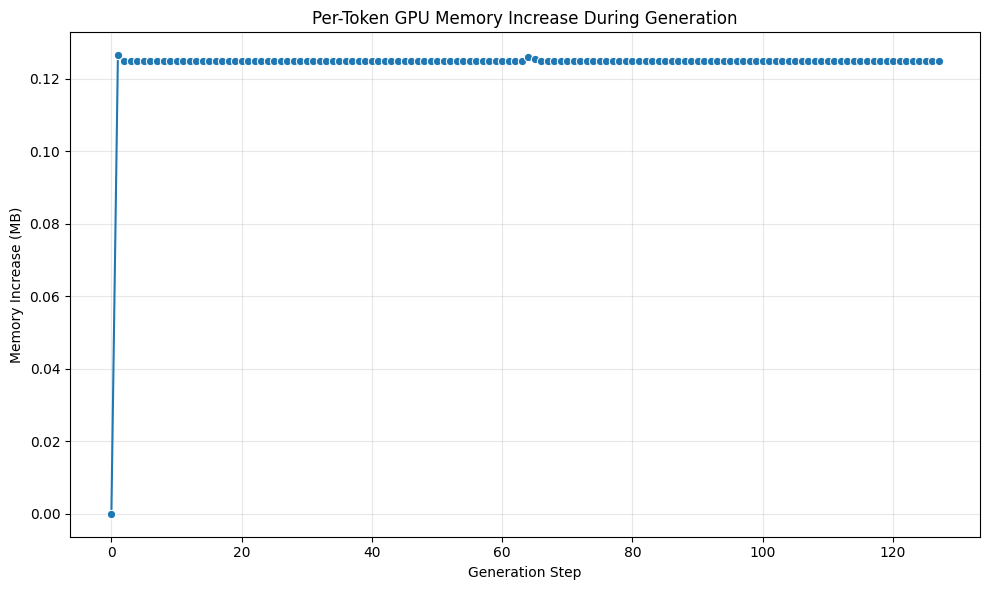

In [7]:
### Cell 8: Experiment 3 - Real-time GPU Memory Usage During Generation
print("--- Experiment 3: Real-time memory trace ---")

df_memory_steps = pd.DataFrame()

if device != "cuda":
    raise RuntimeError("Uh....  requires GPU trace from the previous cell.")


MAX_GENERATION_LENGTH = 128  # TODO: max tokens for traced generation
PROMPT = "Describe the history of artificial intelligence"  # TODO: seed prompt for memory trace
INPUT_LENGTH = 64  # TODO: desired prompt length in tokens

# TODO: prepare input_ids at the specified length
input_ids = torch.randint(0, len(tokenizer), (1, INPUT_LENGTH), device=device)

from transformers.generation import StoppingCriteria
class MemoryUsageCallback(StoppingCriteria):
    def __init__(self, device):
        self.device = device
        self.memory_trace = []
        self.step_count = 0

    def __call__(self, input_ids, scores, **kwargs):
        allocated = torch.cuda.memory_allocated(self.device) / (1024 ** 2)
        self.memory_trace.append(allocated)
        self.step_count += 1
        return False

    def increases_mb(self):
        if len(self.memory_trace) < 2:
            return []
        return [self.memory_trace[i] - self.memory_trace[i-1] for i in range(1, len(self.memory_trace))]

callback = MemoryUsageCallback(device)

# TODO: run warmup generation without callback
with torch.no_grad():
    model.generate(
        input_ids,
        max_new_tokens=MAX_GENERATION_LENGTH,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

# TODO: run traced generation with callback attached
with torch.no_grad():
    model.generate(
        input_ids,
        max_new_tokens=MAX_GENERATION_LENGTH,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        stopping_criteria=[callback]
    )

# TODO: convert callback outputs into df_memory_steps and save CSV
df_memory_steps = pd.DataFrame({
    "step": range(len(callback.memory_trace)),
    "memory_mb": callback.memory_trace,
    "memory_increase_mb": [0] + callback.increases_mb()
})
df_memory_steps.to_csv("./results/task_1_memory_trace.csv", index=False)

import seaborn as sns
# TODO: plot per-token memory increase and save the figure
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_memory_steps, x="step", y="memory_increase_mb", marker="o", ax=ax)
ax.set_xlabel("Generation Step")
ax.set_ylabel("Memory Increase (MB)")
ax.set_title("Per-Token GPU Memory Increase During Generation")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./figures/task_1_memory_trace.png", dpi=300, bbox_inches="tight")
print(df_memory_steps.tail())

In [10]:
### Cell 9: Space Complexity Verification
print("--- Space complexity verification ---")

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(df_memory_steps["step"], df_memory_steps["memory_mb"])
print(f"Linear Regression Results:")
print(f"  Slope: {slope:.4f} MB/token")
print(f"  Intercept: {intercept:.4f} MB")
print(f"  R² value: {r_value**2:.4f}")
print(f"  P-value: {p_value:.4e}")
print(f"  Standard error: {std_err:.4f}")


--- Space complexity verification ---
Linear Regression Results:
  Slope: 0.1250 MB/token
  Intercept: 15370.2852 MB
  R² value: 1.0000
  P-value: 0.0000e+00
  Standard error: 0.0000


In [11]:
### Cell 10: List all generated artifacts for Task 1
print("Task 1 complete. Generated artifacts:")

if os.path.isdir(FIGURES_DIR):
    print(f"\nFigures in {FIGURES_DIR}:")
    for filename in sorted(os.listdir(FIGURES_DIR)):
        if filename.startswith("task_1_"):
            print(f"  - {filename}")
if os.path.isdir(RESULTS_DIR):
    print(f"\nResults in {RESULTS_DIR}:")
    for filename in sorted(os.listdir(RESULTS_DIR)):
        if filename.startswith("task_1_"):
            print(f"  - {filename}")


Task 1 complete. Generated artifacts:

Figures in ./figures:
  - task_1_latency.png
  - task_1_memory_trace.png

Results in ./results:
  - task_1_df_latency.csv
  - task_1_df_temprature.csv
  - task_1_memory_trace.csv
  - task_1_summary_latency.csv
  - task_1_summary_temperature.csv
